# Analysing news sentiment and source bias

### Problem Statement

This project aims to answer the following questions:
1. Given a controversial topic, is the media overall more positive or negative towards it?
2. Are different news sources riddled with their own biases on the topic?
3. Are different countries differing in their sentiments about these controversial topics?

### How we're going to do it
We will be analysing sentiments that we gather from different news articles and then we will be comparing those sentiments across different news sources and across time. This will help us note the change in sentiment over time and also help spot biases in sources and nations by comparing them to the other sources and nations.

### Motivation behind the project
Analyzing the sentiment of different media about certain event is helpful for the goverment to get public attitude. Based on the current attitude, we can predict the public's response to a policy and make some adjustments. There are so many news articles published everyday. By utilizing them, we can extract numerous information and make a better decision. 
Moreover, as consumers of those news articles, being aware of biases in different sources will help us not be negatively influenced by them. For example, if we know source A is predominantly positive and B is always negative, we should read equal number of articles from both sources so we have information from both sides. If we read just A, we will be just positive, and vice versa.
Finally, news articles act as a good source of understanding public sentiment about a country. By comparing the sentiment of articles about a same topic across different countries we will also get an idea of how that country feels about the topic.

## Data Collection

Data has been collected from News API (http://newsapi.org/ ). <br/>
We will be extracting news articles from different sources and specially across different countries. However, as a limitation for our project, we will be using only the news articles written in English, even if the sources are from different countries. 
To ensure we get the most updated data, we are not just retrieving the content provided by the api but also scraping the url ourselves. <br/>
To scrape, we mostly extract all the text which are within paragraphs and then generate a summary out of them.

In [1]:
# Standard imports
import pandas as pd
import json
import requests
import bs4 as bs
import re
from urllib.request import Request, urlopen
from collections import Counter
from datetime import datetime
from collections import defaultdict

# Import news api
from newsapi.newsapi_client import NewsApiClient

# Import nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('vader_lexicon')

# Used for wordcloud
from wordcloud import WordCloud

# heapq is used to get the most important sentences
import heapq

# Used to print progress bar
import tqdm

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhid/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Now we will initialise news api object and ask the user to enter a query word. For this tutorial we chose to use "homosexual" as our key word for the analysis. We decided to chose this word as we view this as a topic that as one that will have a pronounced change in sentiment over time. We also see this as a topic that should have differing opinions in different countries and would be something that we could potentially observe.

The same analysis can be done however on any key word that you input below.

<div class = "alert alert-danger"> <b>Please note:</b> You do not need to run these lines of code and go through the process of data extraction to see the results we received. You can go to the Visualisation section and just read in the CSV file we have prepared for you </div>

In [2]:
# Initialise news api object
api_key = 'c739ce625cc44a2489a36795b6fbcf7e'
newsapi = NewsApiClient(api_key=api_key)

# Get query word
word = "homosexual"

To increase the number of articles on the topic, we will retrieve synonyms of the word and query for each of the synonyms as well

In [3]:
# Get synonyms of query word
def get_synonyms(word):
    synonyms = [] 

    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name())

    return synonyms

query_keywords = get_synonyms(word)

# To get even more results, we will be adding more keywords
query_keywords.extend(['homosexual marriage', 'lesbian', 'gay', 'queer', 'homophobia', 'lgbtq'])
query_keywords = set(query_keywords)

In [4]:
# The final list of keywords in our case are:
query_keywords

{'gay',
 'homo',
 'homophile',
 'homophobia',
 'homosexual',
 'homosexual marriage',
 'lesbian',
 'lgbtq',
 'queer'}

Now we will query the API for news article and store it in a data frame

In [5]:
def get_articles_df():
    articles_df = pd.DataFrame()

    # Sources index: https://newsapi.org/sources. Germany, US, UK, France, India, China
    countries = ['de', 'us', 'gb', 'fr', 'in', 'ch']
    country_source = defaultdict(str)
    
    # Get news sources for each country and store in dictionary
    for country in countries:
        sources = newsapi.get_sources(country=country)['sources']
        country_source[country] = [source['id'] for source in sources]

    # For each word in synonyms list, query the news api and retrieve the news articles
    for country in tqdm.tqdm_notebook(countries):
        country_df = pd.DataFrame()
        for query in query_keywords:
            country_articles = newsapi.get_everything(q=query,
                                          page_size=100, 
                                             language='en',
                                             sources=','.join(country_source[country]))
            country_df = country_df.append(pd.DataFrame(country_articles['articles']))
        country_df['country'] = country
        articles_df = articles_df.append(country_df)

    # Drop all duplicate URLs
    articles_df.drop_duplicates(subset ="url", keep = 'first', inplace = True) 
    
    return articles_df

articles_df = get_articles_df()

In [6]:
# Let's check how many unique articles we got
articles_df.shape

(1366, 9)

<div class="alert alert-danger"> 
    Here, we see that we have <b>1376</b> articles. Note that these may change since the API returns news articles of the past 7 days, so depending on when the code is run, this value may change
</div>

In [7]:
# Let's check what results we get
articles_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content,country
0,"{'id': 'spiegel-online', 'name': 'Spiegel Onli...",SPIEGEL ONLINE,Trans-Atlantic Hate: Neo-Nazi 'Atomwaffen Divi...,German politicians and activists have been the...,https://www.spiegel.de/international/germany/n...,https://cdn1.spiegel.de/images/image-1486954-8...,2019-11-13T20:37:00Z,"November 13, 2019 \r\n09:37 PM\r\nWhen Donna C...",de
0,"{'id': 'the-next-web', 'name': 'The Next Web'}",The Conversation,The sixth mass extinction has already claimed ...,"Nine human species walked the Earth 300,000 ye...",https://thenextweb.com/syndication/2019/11/27/...,https://img-cdn.tnwcdn.com/image/tnw?filter_la...,2019-11-27T12:45:58Z,"Nine human species walked the Earth 300,000 ye...",us
1,"{'id': 'ars-technica', 'name': 'Ars Technica'}",Kiona N. Smith,Did Neanderthals make eagle talon necklaces 12...,"The evidence is indirect, but a recent find su...",https://arstechnica.com/science/2019/11/did-ne...,https://cdn.arstechnica.net/wp-content/uploads...,2019-11-20T16:20:43Z,0 with 0 posters participating\r\nAt Foradada ...,us
2,"{'id': 'the-next-web', 'name': 'The Next Web'}",The Conversation,Human language stops us from understanding how...,"Sarah, “the world’s smartest chimp,” died in J...",https://thenextweb.com/?p=1255016,https://img-cdn.tnwcdn.com/image/tnw?filter_la...,2019-11-11T16:00:14Z,"Sarah, the worlds smartest chimp, died in July...",us
3,"{'id': 'mashable', 'name': 'Mashable'}",Mark Kaufman,Gifts to buy your climate-denying uncle,"NASA scientists, who once engineered spaceship...",https://mashable.com/article/gift-ideas-for-cl...,https://mondrian.mashable.com/2019%252F11%252F...,2019-11-11T14:00:00Z,"NASA scientists, who once engineered spaceship...",us


<div class = "alert alert-success">
    For each article we will focus on the following columns: <br/>
    <ul>
        <li> <b>author</b> - Author of the article </li>
        <li><b>content</b> - Content of the article </li>
        <li><b>source</b> - Source, along with source id and name </li>
        <li><b>title</b> - Title of the article </li>
        <li><b>url</b> - URL of the article </li>
    </ul>
</div>

### Sentiment Analysis

First, we used VADER to get the sentiment

In [8]:
sid = SentimentIntensityAnalyzer()

# Get sentiment from content
def get_sentiment_vader(content):    
    try:
        # Get the polarity score. The higher the better
        polarity = sid.polarity_scores(content)['compound']        
    except:
        polarity = 0
        
    return polarity

# We later chose to use our own so did not add this to the dataframe
# articles_df['sentiment'] = articles_df['content'].apply(get_sentiment)

We decided to try using our own sentiment analysis for this project instead of just using a sentiment intensity analyser. We preprocess the article first removing for stopwords, punctuation and check for its form of speech. We then use the polarity of the words in the sentence to create an overall sentiment for that article. Sentiment is scored from a scale of -1 to 1 where -1 is a highly negative article while 1 is a highly positive article. 


In [9]:
def sentAnalyze(wordList,dictA):
    # use individual sentiments to evaluate the overall sentiment of the article
    pos = 0
    neu = 0
    neg = 0
    for word in wordList:
        try: 
            val = float(dictA[word])
            if val > 0:
                pos += val
            else:
                neg += val
        except:
            pass
    return (pos + neg)

def createPolarityDict():
    #create a polarity dictionary mapping each word to a sentiment
    file1 = open("words.txt","r") 
    dictA = {}
    for elem in file1.readlines():
        ind = elem.index("#")
        word = (elem[:ind].strip())
        score = (elem[ind+2:].strip())
        dictA[word] = score
    return dictA

dictA = createPolarityDict()


def filterPunc(sent):
    return re.sub(r'[^\w\s]','', sent)

def getSentiment(content):
    if content == None:
        return 0
    try:
        finList = []
        stops = stopwords.words("english")
        spanishstops = stopwords.words("spanish")
        count = 0
        stemmer= PorterStemmer()
        wordList = []
        article = content
        tweet = filterPunc(article)
        # split article up
        words = word_tokenize(article)
        for w in words:
            #print(word)
            w = stemmer.stem(w)
            #print(w)
            w = w.lower()
            if w not in stops and w not in spanishstops: 
                wordList.append(w)      
            res = (sentAnalyze(wordList,dictA))
        return res
    except:
        return 0

# Add sentiment as a column to the data frame
articles_df['sentiment'] = articles_df['content'].apply(getSentiment)
# Normalise sentiment to between -1 and 1
maxSentiment = articles_df['sentiment'].abs().max()
articles_df['sentiment'] /= maxSentiment

### Summariser

In [ ]:
# We'll be using the scraper instead of 'content' directly since at times the article is updated but the content column isn't changed.
# The logic is to calculate how many times each word in a sentence has occurred. Accordingly, each sentence gets a score and the ones with the highest scores are chosen to form the summary
def get_summary_from_url(url):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36'})

    source = ""
    try:
        source = urlopen(req).read()           

        # Parsing the data/ creating BeautifulSoup object
        soup = bs.BeautifulSoup(source,'lxml')

        # Fetching the data
        text = ""
        
        # Store all the data in <p> tags in the text variable
        text = ''.join([paragraph.text for paragraph in soup.find_all('p')])
        
        text = re.sub(r'\s+',' ',text)  #Replace the multiple spaces with 1 space
            
        # Clean the text
        clean_text = text.lower()
        clean_text = re.sub(r'\W', ' ', clean_text)   #Delete all non-word characters (punctuations)
        clean_text = re.sub(r'\d', ' ', clean_text)   #Remove digits

        stopWords = list(stopwords.words('english'))
        
        # Create a dictionary of words with their count
        clean_text_list = nltk.word_tokenize(clean_text)
        
        # A counter object containing a word and how many times it occured
        cnt = Counter()
        for word in clean_text_list:
            if(word not in stopWords):
                cnt[word] += 1
        
        # Calculate score of each sentence by adding up scores of the words individually
        sent2score = {}
        for sentence in nltk.sent_tokenize(text):    
            sentCount=0
            #Check such that it's not biased towards long sentences over important sentences
            if(len(sentence.split(' ')) > 25):
                sent2score[sentence] = 0 
            else:
                for word in nltk.word_tokenize(sentence.lower()):        
                    sentCount+=cnt[word]
                sent2score[sentence] = sentCount

        # Calculate top 3 sentences to make the summary
        best_sentences = heapq.nlargest(3, sent2score, key=sent2score.get)    
    except:
        return "Summary not available!!"

    return ''.join(best_sentences)

# Save summary as a column in the dataframe
articles_df['summary'] = articles_df['url'].apply(get_summary_from_url)

### Save Data

In [ ]:
# Save this data frame as a CSV file so that we do not need to run the data collection every time
articles_df.to_csv('articles_all.csv', index=False)

## Data Analysis

In [ ]:
## Read the data again in case you didn't run the data collection code on top
articles_df = pd.read_csv('articles_all.csv')

### Visualizing by time

Visualise sentiment by date to figure out how the sentiment has changed over the past couple of weeks

In [ ]:
def preprocess_data_for_time_analysis(df):
    df=df[["publishedAt", "sentiment", "source"]]

    df['publish'] = pd.to_datetime(df['publishedAt'])
    df['publish'] = df['publish'].dt.date
    
    return df

viz_df = preprocess_data_for_time_analysis(articles_df.copy())

In [ ]:
# Visualising sentiment by date
df_mean = pd.DataFrame(viz_df.groupby("publish")["sentiment"].mean())

data_time  = df_mean.index
data_sentiment = df_mean['sentiment']
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
autodates = AutoDateLocator()           

plt.gca().xaxis.set_major_locator(autodates)
plt.plot(data_time, data_sentiment,'b',lw=2.5)
plt.gcf().autofmt_xdate()  
plt.grid(True)
plt.axis("tight")
plt.xlabel('Time',size=20)
plt.ylabel('Sentiment',size=20)
plt.title('Time_Sentiment',size=20)
plt.show()

<div class="alert alert-success"> <b> Interpretation: </b> In the graph above, we can interpret that the sentiments are fluctuating but on average they are on the slightly positive end. Since it's an aggregation of tens of articles for each day, we did not expect extreme values.</div>

### Visualizing by sources

In this section, we will try to analyse sentiment of the top 10 news sources to decide whether they have prominent biases or not

In [5]:
def preprocess_data_for_source_analysis(df, topN=10):
    media = [eval(d)['name'] for d in df['source']]
    df['media'] = media
    
    topsources = df['media'].value_counts().index[:topN]
    df = df[df['media'].isin(topsources)]
    return df

viz_sources_df=preprocess_data_for_source_analysis(articles_df.copy())

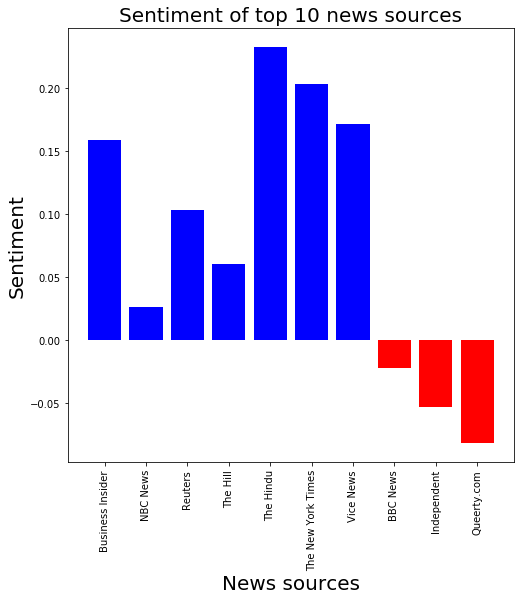

In [6]:
df_mean = pd.DataFrame(viz_sources_df.groupby("media")["sentiment"].mean())
x = df_mean.index
y = df_mean.sentiment

mask1 = y>=0
mask2 = y<0

fig= plt.figure(figsize=(8,8))

plt.bar(x[mask1], y[mask1], color='blue')
plt.bar(x[mask2], y[mask2], color='red')

plt.xticks(rotation=90, ha='center')
plt.xlabel("News sources", fontsize=20)
plt.ylabel("Sentiment", fontsize=20)
plt.title("Sentiment of top 10 news sources", fontsize=20)

plt.show()

<div class="alert alert-success"> <b> Interpretation: </b>Among the top 10 media, on average, BBC News, Independent, and Queerty have a negative attitude. And Business Insider, The Hindu, The New York Times, and Vice News have the most positive attitude. <br/>
It seems like The Hindu, The NY Times, and Vice News are significantly positive compared to the rest of the news sources which have a more moderate sentiment.</div>

### Visualizing top source by time

Now we will be visualising the sentiment of the news source with the maximum number of articles on the given topic. Note: This may also vary depending on when the code cells are executed

In [7]:
def preprocess_data_for_source_time_analysis(df):
    df = preprocess_data_for_time_analysis(df)
    df = preprocess_data_for_source_analysis(df, 1)
    
    print("The news source with the maximum number of articles is: ", df.media.unique()[0])
    df = df.groupby('publish').mean().reset_index()
    df = df.set_index(["publish"])
    return df

viz_sources_time_df = preprocess_data_for_source_time_analysis(articles_df.copy())

C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

The news source with the maximum number of articles is:  Independent


Text(0, 0.5, 'Sentiment')

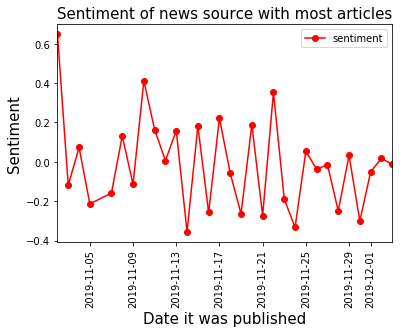

In [8]:
viz_sources_time_df.plot(kind='line',marker='o',color='r')
plt.xticks(rotation=90, ha='center')
plt.title("Sentiment of news source with most articles", fontsize=15)
plt.xlabel("Date it was published", fontsize=15)
plt.ylabel("Sentiment", fontsize=15)

<div class="alert alert-success"> In our case, Independent was the news source with the maximum number of articles. However, from what we can see, the sentiment fluctuated a lot and it was mostly close to neutral, with one outlier. This is a good sign, it's an indication that the Independent does not have inherent biases and prints articles from both sides of the topic.</div>


### In depth analysis of what the top source talks about

In this sub-section, we will be analysing what the top source - in our case, Independent, talks most about in their articles. We will be using WordCloud for this analysis

In [32]:
def get_wordcloud_text(df):
    df = preprocess_data_for_source_analysis(df, 1)
    
    # Get all the text
    text = df['description'].tolist()
    text = ''.join(text)
    
    # Clean text
    clean_text = text.lower()
    clean_text = re.sub(r'\W', ' ', clean_text)   #Delete all non-word characters (punctuations)
    clean_text = re.sub(r'\d', ' ', clean_text)   #Remove digits

    return clean_text
    
wordcloud_text = get_wordcloud_text(articles_df.copy())

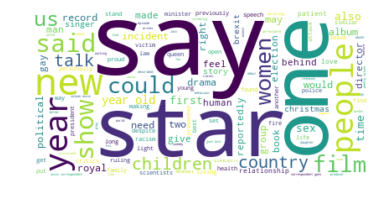

In [36]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = list(stopwords.words('english')), background_color="white").generate(wordcloud_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div class="alert alert-success"> We can see that Independent talks a lot about "say", "stay", "gay", "right", "women", and "people". It looks like there are a lot of articles about fundamental human rights and freedom to speech. The word "said" might be so common because news articles generally contain a lot of testimonies. What's also interesting is that "film" is also one of the important words. This signifies that there is a lot of talk about homosexuality even in the media and entertainment industry. We can also see that there aren't many negative words in this wordcloud which is good. </div>

## Analysing articles by country

In this section, we will be analysing the articles by country to find out whether sentiment in certain countries vary a lot from the rest of the world 

### Visualising number of articles by country

In [9]:
def preprocess_data_for_country_analysis(df):    
    country_dict = {"de": "Germany", "ch": "China", "us": "USA", "in": "India", "gb": "UK"}
    continent_dict = {"de": "Europe", "ch": "Asia", "us": "North America", "in": "Asia", "gb": "Europe"}
    
    df["country_label"] = df["country"].map(country_dict)
    df["continent"] = df["country"].map(continent_dict)
    
    df = df[["country_label", "sentiment", "continent"]]
    return df
viz_country_df = preprocess_data_for_country_analysis(articles_df.copy())

Text(0.5, 0, 'Country')

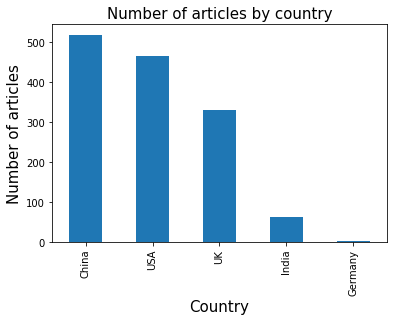

In [10]:
viz_country_df['country_label'].value_counts().plot(kind='bar')
plt.title("Number of articles by country", fontsize=15)
plt.ylabel("Number of articles", fontsize=15)
plt.xlabel("Country", fontsize=15)

<div class="alert alert-success"> <b>China</b> has maximum number of news articles revolving around homosexuality in the past month (500+ is a shocking number of articles) <br/>
    On the flip side, <b>Germany</b> has a surprisingly low number of news articles (just 1 in the past month). One probable reason is that news articles in Germany might not be written in English, and we've extracted articles only in English </div>

### Visualizing sentiment by country

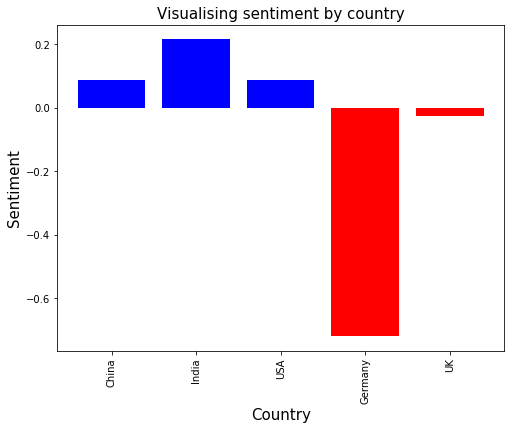

In [11]:
df_mean = pd.DataFrame(viz_country_df.groupby("country_label")["sentiment"].mean())

x = df_mean.index
y = df_mean.sentiment

mask1 = y>=0
mask2 = y<0
fig = plt.figure(figsize=(8,6))
plt.bar(x[mask1], y[mask1], color='blue')
plt.bar(x[mask2], y[mask2], color='red')
plt.xticks(rotation=90, ha='center')
plt.title("Visualising sentiment by country", fontsize=15)
plt.xlabel("Country", fontsize=15)
plt.ylabel("Sentiment", fontsize=15)
plt.show()

<div class="alert alert-success"> 
    <b>Germany</b> is the only one with an overall negative sentiment on homosexuality. This might also be because we could just extract 1 article in English written by the German news sources. <b> India</b> seems to have the most positive sentiment on homosexuality which was a shock given that I'm from India and it is a more conservative society compared to other countries like the USA. China, UK, and the US seem to have a similarly positive sentiment on homesexuality. This seems like the world has progressed and is doing well.
    </div>

### Visualising sentiment by continent

For some further analysis, we will be aggregating further and visualising sentiment by continent

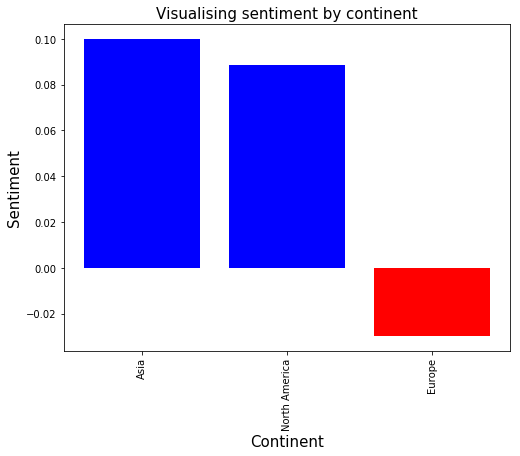

In [12]:
df_mean = pd.DataFrame(viz_country_df.groupby("continent")["sentiment"].mean())
x = df_mean.index
y = df_mean.sentiment

mask1 = y>=0
mask2 = y<0
fig = plt.figure(figsize=(8,6))
plt.bar(x[mask1], y[mask1], color='blue')
plt.bar(x[mask2], y[mask2], color='red')
plt.xticks(rotation=90, ha='center')
plt.title("Visualising sentiment by continent", fontsize=15)
plt.xlabel("Continent", fontsize=15)
plt.ylabel("Sentiment", fontsize=15)
plt.show()

<div class="alert alert-success"> This shows that the sentiment in Asia and North America is more positive whereas Europe is slightly negative. </div>

## Conclusion

Overall, we can conclude that the world has a more positive sentiment when it comes to homosexuality. This is good news and we have a lot of LGBTQ rights protests to thank. More specifically, <b>India</b> seems to be more progressive in having a more positive sentiment than the other countries we measured. As for news sources, <b>Independent</b> seems to write a lot about homosexuality and it doesn't depict a bias towards any stance. Therefore, it seems like a good news source to follow to get unopinionated news on the matter. On the other hand, The NY Times and the Hindu seem to be overly positive on the matter.

There are tons of other analyses which could be done but this is the best we could come up with given our limited time and resources. We will talk about what further analysis we could do in the "Further Investigation" section

## Further Investigation

Our project had 2 main limtations: 
1. We had a limitation of a certain number of articles we could extract for each keyword from the API.
2. We had a limitation that for all the countries, we could only extract news articles written in English
A more thorough analysis could be done if we are able to relieve ourselves of these limitations and are able to extract more data. In most foreign countries (eg: India), articles written in English may be a little more progressive when compared to articles written in the native languages as these articles tend to have a more western influence.

Future steps for Analyses:
1. We could add more countries and news sources to get a more robust comparison. <br/>
2. We could add more keywords and compare different countries, sources across different keywords as well. For example, India is more positive for homosexuality but there could be a different result if we choose another topic like religion and casteism
3. The summariser built for this project was extractive, since it was the means to an end but given more time, we would like to build an abstractive summariser which provides more accurate summaries

## Related work

According to a study by the Williams Institute, a majority of countries have changed their attitude about homosexuality and gay rights towards greater acceptance. But the trends are moderate in magnitude. It is similar with our results "Most media hold a neutral attitude".
https://williamsinstitute.law.ucla.edu/wp-content/uploads/public-attitudes-nov-2014.pdf

# Sources

- The polarity of different words was obtained from SentiWords.